In [ ]:
from IPython import get_ipython
ipython_shell = get_ipython()
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib inline
import time
from datetime import datetime
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r, numpy2ri, FloatVector, pandas2ri
from datetime import timedelta
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

## 時間函數


In [ ]:

start = str(sys.argv[1]) + ' 00:00:00' #input('起始日期：(格式:2019-01-01)')
end = str(sys.argv[2]) + ' 23:00:00' #input('結束日期：(格式:2019-10-17)')
time_step = int(sys.argv[3]) #int(input('預報小時：(格式:96)'))
ver = str(sys.argv[4]).split(',')           #[int(num) for num in input("請輸入全部的版本(格式：17 18),以空白鍵區隔：").split(",")] 


'\nstart = str(sys.argv[1]) + \' 00:00:00\' #input(\'起始日期：(格式:2019-01-01)\')\nend = str(sys.argv[2]) + \' 23:00:00\' #input(\'結束日期：(格式:2019-10-17)\')\ntime_step = int(sys.argv[3]) #int(input(\'預報小時：(格式:96)\'))\nver = str(sys.argv[4]).split(\',\')           #[int(num) for num in input("請輸入全部的版本(格式：17 18),以空白鍵區隔：").split(",")] \n'

In [ ]:
'''
start = '2019-01-01' + ' 00:00:00' #input('起始日期：(格式:2019-01-01)')
end = '2019-09-30' + ' 23:00:00' #input('結束日期：(格式:2019-10-17)')
time_step = int(72) #int(input('預報小時：(格式:96)'))
ver = [17, 18, 30]           #[int(num) for num in input("請輸入全部的版本(格式：17 18),以空白鍵區隔：").split(",")] 
'''

# Z_Observation

In [ ]:
time_interval = time_step//24

In [ ]:
def data_cleaning(df):
    
    
    df['year'] = df['year'].astype(str)
    df['month'] = df['month'].astype(str)
    df['day'] = df['day'].astype(str)
    df['hour'] = df['hour'].astype(str)
    df['dateTime'] = df['year'] + '-' + df['month'].str.zfill(2) + '-' + df['day'].str.zfill(2) + ' ' + df['hour'].str.zfill(2) +':'+ '00:00 '
    df['dateTime'] = pd.to_datetime(df['dateTime']).apply(lambda x:int(time.mktime(x.timetuple())))
    df.sort_values(by=['dateTime', 'stationID'], inplace = True)
    
    return df

## 定義所採納的時間

In [ ]:
start = time.strptime(start, "%Y-%m-%d %H:%M:%S")
end = time.strptime(end, "%Y-%m-%d %H:%M:%S")

# 轉換為時間戳:
start = int(time.mktime(start)) - 3600*24
end = int(time.mktime(end))

## 取時間範圍start-end

#### 舊的檔案和新的檔案時間範圍定義

In [ ]:
new_observation = pd.read_table("opendata_epa.txt") 
new_observation = data_cleaning(new_observation)

In [ ]:
file_name = 'old_opendata_epa_' + str(time_step) + '.txt'

try:
    old_observation = pd.read_table(file_name)
    old_observation = data_cleaning(old_observation)
    old_end = old_observation['dateTime'].iloc[-1] + 3600
    old_start = old_observation['dateTime'].iloc[0] - 3600 
    new_observation = new_observation[new_observation['dateTime'] >= old_end]
    pre_observation = new_observation[new_observation['dateTime'] <= old_start]#########
    df_observation = pd.concat([pre_observation, old_observation, new_observation], axis = 0, ignore_index=True)
    print('舊檔新檔合併')
except IOError:
    df_observation = new_observation
    print('讀取新檔')

舊檔新檔合併


In [ ]:
df_observation = df_observation[df_observation['dateTime'].between(start,end + (time_interval-1) * 3600 * 24)] ##########

df_observation['dateTime'] = df_observation['dateTime'].apply(lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x)))
df_observation.sort_values(by=['dateTime', 'stationID'], inplace = True)
opendata_station = list(pd.unique(df_observation['stationID']))

df_observation.tail()

,year,month,day,hour,stationID,PMf,dateTime
488395,2019,10,2,23,EPA071,48.0,2019-10-02 23:00:00
488396,2019,10,2,23,EPA072,41.0,2019-10-02 23:00:00
488397,2019,10,2,23,EPA080,12.0,2019-10-02 23:00:00
488398,2019,10,2,23,EPA102,62.0,2019-10-02 23:00:00
488399,2019,10,2,23,EPA110,52.0,2019-10-02 23:00:00


## 移除測站'EPA101',' EPA084','EPA104'(因為全部皆為NAN)

In [ ]:
df_observation = df_observation[df_observation['stationID']!='EPA101']
df_observation = df_observation[df_observation['stationID']!='EPA084']
df_observation = df_observation[df_observation['stationID']!='EPA104']
df_observation.tail()

,year,month,day,hour,stationID,PMf,dateTime
499976,2019,10,2,23,EPA071,48.0,2019-10-02 23:00:00
499977,2019,10,2,23,EPA072,41.0,2019-10-02 23:00:00
499978,2019,10,2,23,EPA080,12.0,2019-10-02 23:00:00
499981,2019,10,2,23,EPA102,62.0,2019-10-02 23:00:00
499983,2019,10,2,23,EPA110,52.0,2019-10-02 23:00:00


In [ ]:
station_num = len(np.unique(df_observation['stationID'])) ##測站總數

## 進行時間缺漏值填補

In [ ]:
stations = list(pd.unique(df_observation['stationID']))

In [ ]:
print('-------observation 填補日期缺失值---------')
df_observation['dateTime'] = pd.to_datetime(df_observation['dateTime']).apply(lambda x:int(time.mktime(x.timetuple())))
df_observation.index = np.arange(len(df_observation))
a = df_observation['dateTime'][0] ########################
b = int(df_observation['dateTime'][-1:].values)
all_date= list(range(a,b,3600))+[b]
df_add = df_observation[: 1].copy()
for name in stations:
    #print('name', name)
    unnormal = list(df_observation[df_observation['stationID'] == name]['dateTime'])
    dates = list(set(all_date).difference(set(unnormal)))
    #print('date',len(dates))
    
    for date in dates:
        df_add['dateTime'] = date
        df_add['stationID'] = name
        df_add['PMf'] = np.nan
        df_observation = pd.concat([df_observation, df_add])
    df_observation.sort_values(by=['dateTime','stationID'], inplace = True)


-------observation 填補日期缺失值---------


In [ ]:
df_observation['dateTime'] = df_observation['dateTime'].apply(lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x)))
df_observation['month'] = pd.to_datetime(df_observation['dateTime']).dt.month
df_observation['year'] = pd.to_datetime(df_observation['dateTime']).dt.year
df_observation['day'] = pd.to_datetime(df_observation['dateTime']).dt.day
df_observation['hour'] = pd.to_datetime(df_observation['dateTime']).dt.hour

df_observation.head()

,year,month,day,hour,stationID,PMf,dateTime
0,2019,1,1,0,EPA001,4.0,2019-01-01 00:00:00
1,2019,1,1,0,EPA002,10.0,2019-01-01 00:00:00
2,2019,1,1,0,EPA003,7.0,2019-01-01 00:00:00
3,2019,1,1,0,EPA004,5.0,2019-01-01 00:00:00
4,2019,1,1,0,EPA005,4.0,2019-01-01 00:00:00


### 檢查補植後結果 1:補植成功 ; 不為1:補植失敗

In [ ]:
if len(np.unique(pd.value_counts(df_observation['stationID'])))==1:
    print('observation 缺失日期補值成功')
else:
    print('observation 缺失日期補值失敗')

observation 缺失日期補值成功


In [ ]:
df_observation.to_csv(file_name, sep='\t', index=False)
df_observation['date'] = df_observation['dateTime'].apply(lambda x:time.strftime("%Y-%m-%d",time.strptime(x,'%Y-%m-%d %H:%M:%S')))

## 轉為一天為單位的矩陣

In [ ]:
one_day_df = np.array(df_observation['PMf']).reshape(-1, station_num * 24)
one_day_df

array([[ 4., 10.,  7., ...,  6., 25.,  9.],
       [ 3.,  5.,  5., ...,  9., 29., 10.],
       [ 4.,  6.,  5., ...,  8., 33.,  9.],
       ...,
       [ 8.,  8.,  7., ...,  7.,  9., 13.],
       [ 6.,  5.,  8., ...,  3., 39., 23.],
       [10., 17.,  9., ..., 12., 62., 52.]])

In [ ]:
index = pd.unique(df_observation['date'] ).astype(str)
observation_z = pd.DataFrame(columns=np.arange(station_num*24), data = one_day_df,index = index)
observation_y1 =  observation_z.copy()
observation_z.head()

,0,1,2,3,4,5,6,7,8,9,...,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775
2019-01-01,4.0,10.0,7.0,5.0,4.0,10.0,4.0,1.0,4.0,11.0,...,1.0,10.0,6.0,19.0,4.0,25.0,16.0,6.0,25.0,9.0
2019-01-02,3.0,5.0,5.0,2.0,11.0,6.0,3.0,5.0,4.0,9.0,...,1.0,10.0,14.0,10.0,6.0,33.0,43.0,9.0,29.0,10.0
2019-01-03,4.0,6.0,5.0,1.0,10.0,8.0,1.0,6.0,6.0,11.0,...,1.0,13.0,6.0,34.0,5.0,31.0,15.0,8.0,33.0,9.0
2019-01-04,4.0,4.0,7.0,3.0,8.0,8.0,0.0,5.0,4.0,7.0,...,3.0,42.0,23.0,78.0,42.0,54.0,85.0,3.0,17.0,40.0
2019-01-05,26.0,40.0,20.0,29.0,53.0,42.0,30.0,37.0,12.0,23.0,...,14.0,16.0,6.0,50.0,9.0,41.0,30.0,0.0,8.0,17.0


In [ ]:
observation_z.tail()

,0,1,2,3,4,5,6,7,8,9,...,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775
2019-09-28,4.0,5.0,0.0,7.0,4.0,4.0,4.0,3.0,4.0,7.0,...,2.0,15.0,10.0,15.0,3.0,31.0,10.0,0.0,21.0,13.0
2019-09-29,4.0,4.0,4.0,1.0,5.0,1.0,6.0,6.0,8.0,5.0,...,8.0,18.0,11.0,23.0,6.0,18.0,29.0,3.0,30.0,11.0
2019-09-30,8.0,8.0,7.0,5.0,10.0,4.0,11.0,9.0,10.0,7.0,...,1.0,18.0,9.0,3.0,4.0,12.0,5.0,7.0,9.0,13.0
2019-10-01,6.0,5.0,8.0,1.0,5.0,10.0,7.0,4.0,6.0,7.0,...,3.0,26.0,13.0,12.0,7.0,33.0,9.0,3.0,39.0,23.0
2019-10-02,10.0,17.0,9.0,5.0,13.0,16.0,16.0,8.0,9.0,15.0,...,8.0,43.0,59.0,37.0,9.0,48.0,41.0,12.0,62.0,52.0


## 將PMF=NAN進行補值

### 引入R的套件

In [ ]:
#%load_ext rpy2.ipython


In [ ]:
#%R install.packages('devtools')
robjects.r('install.packages("devtools")')
#robjects.r('if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")')
#robjects.r('BiocManager::install()')
#robjects.r('source("https://bioconductor.org/biocLite.R")')

r('''devtools::install_github("marchtaylor/sinkr")''')

array([0], dtype=int32)

In [ ]:
devtools = importr('devtools')
sinkr = importr('sinkr')

In [ ]:
numpy2ri.activate()
pandas2ri.activate()
rpy2_observation_z = pandas2ri.py2ri(observation_z)
robjects.r.assign('rpy2_observation_z', rpy2_observation_z)

X0,X1,X2,...,X1773,X1774,X1775
4.000000,10.000000,7.000000,...,6.000000,25.000000,9.000000
3.000000,5.000000,5.000000,...,9.000000,29.000000,10.000000
4.000000,6.000000,5.000000,...,8.000000,33.000000,9.000000
4.000000,4.000000,7.000000,...,3.000000,17.000000,40.000000
...,...,...,...,...,...,...
4.000000,4.000000,4.000000,...,3.000000,30.000000,11.000000
8.000000,8.000000,7.000000,...,7.000000,9.000000,13.000000
6.000000,5.000000,8.000000,...,3.000000,39.000000,23.000000
10.000000,17.000000,9.000000,...,12.000000,62.000000,52.000000


In [ ]:
r('''
rpy2_observation_z[is.na(rpy2_observation_z)]<- NaN
y <- data.matrix(rpy2_observation_z)
Ya <- dineof(y)$Xa
observation_z<-data.frame(Ya)
head(rpy2_observation_z)
''')

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X1766,X1767,X1768,X1769,X1770,X1771,X1772,X1773,X1774,X1775
0,4.0,10.0,7.0,5.0,4.0,10.0,4.0,1.0,4.0,11.0,...,1.0,10.0,6.0,19.0,4.0,25.0,16.0,6.0,25.0,9.0
1,3.0,5.0,5.0,2.0,11.0,6.0,3.0,5.0,4.0,9.0,...,1.0,10.0,14.0,10.0,6.0,33.0,43.0,9.0,29.0,10.0
2,4.0,6.0,5.0,1.0,10.0,8.0,1.0,6.0,6.0,11.0,...,1.0,13.0,6.0,34.0,5.0,31.0,15.0,8.0,33.0,9.0
3,4.0,4.0,7.0,3.0,8.0,8.0,0.0,5.0,4.0,7.0,...,3.0,42.0,23.0,78.0,42.0,54.0,85.0,3.0,17.0,40.0
4,26.0,40.0,20.0,29.0,53.0,42.0,30.0,37.0,12.0,23.0,...,14.0,16.0,6.0,50.0,9.0,41.0,30.0,0.0,8.0,17.0
5,4.0,4.0,4.0,1.0,14.0,7.0,4.0,8.0,4.0,7.0,...,1.0,11.0,6.0,20.0,3.0,33.0,25.0,6.0,14.0,14.0


## 補值過後的observation

#### R dataframe 轉換 pandas

In [ ]:
r.data('observation_z')
df_nomissing = pd.DataFrame(r['observation_z'])
df_nomissing.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X1766,X1767,X1768,X1769,X1770,X1771,X1772,X1773,X1774,X1775
0,4.0,10.0,7.0,5.0,4.0,10.0,4.0,1.0,4.0,11.0,...,1.0,10.0,6.0,19.0,4.0,25.0,16.0,6.0,25.0,9.0
1,3.0,5.0,5.0,2.0,11.0,6.0,3.0,5.0,4.0,9.0,...,1.0,10.0,14.0,10.0,6.0,33.0,43.0,9.0,29.0,10.0
2,4.0,6.0,5.0,1.0,10.0,8.0,1.0,6.0,6.0,11.0,...,1.0,13.0,6.0,34.0,5.0,31.0,15.0,8.0,33.0,9.0
3,4.0,4.0,7.0,3.0,8.0,8.0,0.0,5.0,4.0,7.0,...,3.0,42.0,23.0,78.0,42.0,54.0,85.0,3.0,17.0,40.0
4,26.0,40.0,20.0,29.0,53.0,42.0,30.0,37.0,12.0,23.0,...,14.0,16.0,6.0,50.0,9.0,41.0,30.0,0.0,8.0,17.0


In [ ]:
observation_z = pd.DataFrame(columns=np.arange(station_num * time_step), data = np.nan,index = index)
observation_z.head()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_nomissing = np.array(df_nomissing)
for i in range(len(observation_z)):
    try:
        observation_z.iloc[i,:]  = np.vstack(df_nomissing[i + np.arange(time_interval)]).flatten()
    except:
        continue
observation_z.tail()


,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-09-28,4.0,5.0,0.0,7.0,4.0,4.0,4.0,3.0,4.0,7.0,...,1.0,18.0,9.0,3.0,4.0,12.0,5.0,7.0,9.0,13.0
2019-09-29,4.0,4.0,4.0,1.0,5.0,1.0,6.0,6.0,8.0,5.0,...,3.0,26.0,13.0,12.0,7.0,33.0,9.0,3.0,39.0,23.0
2019-09-30,8.0,8.0,7.0,5.0,10.0,4.0,11.0,9.0,10.0,7.0,...,8.0,43.0,59.0,37.0,9.0,48.0,41.0,12.0,62.0,52.0
2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Observation_y

In [ ]:
observation_y = pd.DataFrame(columns=np.arange(station_num * time_step), data = np.nan,index = index)
for i in range(len(observation_y)):
    try:
        observation_y.iloc[i,:]  = np.vstack(np.array(observation_y1)[i + np.arange(time_interval)]).flatten()
    except:
        continue
observation_y.index = index

observation_y.tail()


,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-09-28,4.0,5.0,0.0,7.0,4.0,4.0,4.0,3.0,4.0,7.0,...,1.0,18.0,9.0,3.0,4.0,12.0,5.0,7.0,9.0,13.0
2019-09-29,4.0,4.0,4.0,1.0,5.0,1.0,6.0,6.0,8.0,5.0,...,3.0,26.0,13.0,12.0,7.0,33.0,9.0,3.0,39.0,23.0
2019-09-30,8.0,8.0,7.0,5.0,10.0,4.0,11.0,9.0,10.0,7.0,...,8.0,43.0,59.0,37.0,9.0,48.0,41.0,12.0,62.0,52.0
2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
observation_y.head()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-01-01,4.0,10.0,7.0,5.0,4.0,10.0,4.0,1.0,4.0,11.0,...,1.0,13.0,6.0,34.0,5.0,31.0,15.0,8.0,33.0,9.0
2019-01-02,3.0,5.0,5.0,2.0,11.0,6.0,3.0,5.0,4.0,9.0,...,3.0,42.0,23.0,78.0,42.0,54.0,85.0,3.0,17.0,40.0
2019-01-03,4.0,6.0,5.0,1.0,10.0,8.0,1.0,6.0,6.0,11.0,...,14.0,16.0,6.0,50.0,9.0,41.0,30.0,0.0,8.0,17.0
2019-01-04,4.0,4.0,7.0,3.0,8.0,8.0,0.0,5.0,4.0,7.0,...,1.0,11.0,6.0,20.0,3.0,33.0,25.0,6.0,14.0,14.0
2019-01-05,26.0,40.0,20.0,29.0,53.0,42.0,30.0,37.0,12.0,23.0,...,1.0,20.0,40.0,33.0,15.0,39.0,25.0,7.0,14.0,24.0


# ----------------------------------------------------------------------------------------

# Prediction

In [ ]:
def getEveryDay(begin_date,end_date):
    date_list = []
    begin_date = datetime.strptime(begin_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date,"%Y-%m-%d")
    while begin_date <= end_date:
        date_str = begin_date.strftime("%Y-%m-%d")
        date_list.append(date_str)
        begin_date += timedelta(days=1)
        
    return date_list

In [ ]:
def data_cleaning_pred(df):
    
    df['expdate'] = pd.to_datetime(df['expdate']).apply(lambda x:int(time.mktime(x.timetuple())))
    
    return df

## 讀取檔案

In [ ]:
name = 'stat_v' 
for i in ver:
    new_name = name + str(i) + '.txt'
    prediction= pd.read_table(new_name)
    if i == ver[0]:
        new_prediction = prediction
    else:
        new_prediction = pd.concat([new_prediction, prediction], axis=0, sort = False)
new_prediction = data_cleaning_pred(new_prediction)

## 新舊資料合併

In [ ]:
pre_file_name = 'old_preciction' + str(time_step) + '.txt'

try:
    old_prediction = pd.read_table(pre_file_name)
    old_prediction = data_cleaning_pred(old_prediction)
    old_end = old_prediction['expdate'].iloc[-1] + 3600
    new_prediction = new_prediction[new_prediction['expdate']>=old_end]
    df_prediction = pd.concat([old_prediction, new_prediction], axis = 0, ignore_index=True)
except IOError:
    df_prediction = new_prediction
    
pre_start = start - 3600*24
df_prediction = df_prediction[df_prediction['expdate'].between(pre_start, end - 3600 * 24)]
df_prediction['expdate'] = df_prediction['expdate'].apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x))) 
df_prediction.sort_values(by=['expdate', 'tau', 'stationID'], inplace = True)
df_prediction.tail()

C:\Users\User\Anaconda3\envs\tf2_rpy2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,calPMf,day,expdate,hour,month,stationID,tau,year
1454539,71.708890,2,2019-09-29,23,10,EPA071,72,2019
1454540,2.563082,2,2019-09-29,23,10,EPA072,72,2019
1454541,0.654434,2,2019-09-29,23,10,EPA080,72,2019
1454542,NaN,2,2019-09-29,23,10,EPA102,72,2019
1454543,8.045380,2,2019-09-29,23,10,EPA110,72,2019


## 拿取預測值、測站移除

In [ ]:
df_prediction = df_prediction[df_prediction['tau']!=0]
df_prediction = df_prediction[df_prediction['tau'] <= time_step]

df_prediction = df_prediction[df_prediction['stationID']!='EPA101']
df_prediction = df_prediction[df_prediction['stationID']!='EPA084']
df_prediction = df_prediction[df_prediction['stationID']!='EPA104']
df_prediction.head()

,calPMf,day,expdate,hour,month,stationID,tau,year
0,NaN,1,2018-12-31,0,1,EPA001,1,2019
1,NaN,1,2018-12-31,0,1,EPA002,1,2019
2,NaN,1,2018-12-31,0,1,EPA003,1,2019
3,NaN,1,2018-12-31,0,1,EPA004,1,2019
4,NaN,1,2018-12-31,0,1,EPA005,1,2019


## 日期、時間缺漏值進行填補

In [ ]:
def otherStyleTime(timestamp):
    timeArray = time.localtime(timestamp)
    date = time.strftime("%Y-%m-%d", timeArray)
    return(date)

In [ ]:
start_pre = otherStyleTime(start)
end_pre = otherStyleTime(end - 3600 * 24)

In [ ]:
for name in stations:
    if sum(pd.value_counts(df_prediction[df_prediction['stationID']==name]['expdate']) != time_step)>0:
        print(name)

In [ ]:
stations = df_prediction['stationID'].unique()
all_expdate = getEveryDay(start_pre, end_pre)

print('------prediction 補缺失日期開始------')
for name in stations:
    
    # 補一整天皆缺失的值
    unnormal = list(df_prediction[df_prediction['stationID'] == name]['expdate'])
    dates = list(set(all_expdate).difference(set(unnormal)))
    
    for date in dates:
        df_add = df_prediction[: time_step].copy()
        df_add['expdate'] = date
        df_add['hour'] = list(np.arange(24))*time_interval
        df_add['stationID'] = name
        df_add['tau'] = np.arange(time_step) + 1
        
        day = []
        month = []
        year = []
        for time in range(1, time_interval+1):
            day += [(pd.to_datetime(date) + timedelta(days=time)).day] * 24 
            month += [(pd.to_datetime(date) + timedelta(days=time)).month] * 24 
            year += [(pd.to_datetime(date) + timedelta(days=time)).year] * 24 
        df_add['day'] = day
        df_add['month'] = month
        df_add['year'] = year
        df_add['calPMf'] = np.nan
        df_prediction = pd.concat([df_prediction, df_add])

    df_prediction.sort_values(by=['expdate', 'tau', 'stationID'], inplace = True)

    # 補部分缺失的值
    if sum(pd.value_counts(df_prediction[df_prediction['stationID']==name]['expdate']) != time_step)>0:
        count = pd.value_counts(df_prediction[df_prediction['stationID']==name]['expdate']).values
        index = pd.value_counts(df_prediction[df_prediction['stationID']==name]['expdate']).index
        for expdate in index[count!=time_step]:
            all_hour = np.arange(time_step) + 1
            unnormal = df_prediction[df_prediction['stationID']==name][df_prediction['expdate']==expdate]['tau']
            taus = list(set(all_hour).difference(set(unnormal)))
            num = len(hours)

            df_add = df_prediction[: len(taus)].copy()
            df_add['expdate'] = expdate  
            df_add['hour'] = taus % 24 
            df_add['stationID'] = name
            df_add['tau'] = taus
            df_add['day'] = (pd.to_datetime(date) + timedelta(hours=23+taus)).day
            df_add['month'] = (pd.to_datetime(date) + timedelta(hours=23+taus)).month
            df_add['year'] = (pd.to_datetime(date) + timedelta(hours=23+taus)).year
            df_add['calPMf'] = np.nan
            df_prediction = pd.concat([df_prediction, df_add])

    df_prediction.sort_values(by=['expdate', 'tau', 'stationID'], inplace = True)
    print('stations:', name)

------prediction 補缺失日期開始------
stations: EPA001
stations: EPA002
stations: EPA003
stations: EPA004
stations: EPA005
stations: EPA006
stations: EPA007
stations: EPA008
stations: EPA009
stations: EPA010
stations: EPA011
stations: EPA012
stations: EPA013
stations: EPA014
stations: EPA015
stations: EPA016
stations: EPA017
stations: EPA018
stations: EPA019
stations: EPA020
stations: EPA021
stations: EPA022
stations: EPA023
stations: EPA024
stations: EPA025
stations: EPA026
stations: EPA027
stations: EPA028
stations: EPA029
stations: EPA030
stations: EPA031
stations: EPA032
stations: EPA033
stations: EPA034
stations: EPA035
stations: EPA036
stations: EPA037
stations: EPA038
stations: EPA039
stations: EPA040
stations: EPA041
stations: EPA042
stations: EPA043
stations: EPA044
stations: EPA045
stations: EPA046
stations: EPA047
stations: EPA048
stations: EPA049
stations: EPA050
stations: EPA051
stations: EPA052
stations: EPA053
stations: EPA054
stations: EPA056
stations: EPA057
stations: EPA058


In [ ]:
if len(np.unique(pd.value_counts(df_prediction['stationID'])))==1:
    print('prediction 缺失日期補值成功')
else:
    print('prediction 缺失日期補值失敗')

prediction 缺失日期補值成功


In [ ]:
df_prediction = df_prediction[['expdate','stationID','year','month','day','hour','tau','calPMf']]
df_prediction.head()

,expdate,stationID,year,month,day,hour,tau,calPMf
0,2018-12-31,EPA001,2019,1,1,0,1,NaN
1,2018-12-31,EPA002,2019,1,1,0,1,NaN
2,2018-12-31,EPA003,2019,1,1,0,1,NaN
3,2018-12-31,EPA004,2019,1,1,0,1,NaN
4,2018-12-31,EPA005,2019,1,1,0,1,NaN


In [ ]:
df_prediction.to_csv(pre_file_name, sep='\t', index=False)  

## 將tau = 1的日期設為index

In [ ]:
df_pred = pd.DataFrame(np.array(df_prediction['calPMf']).reshape([-1, time_step * station_num]))
df_pred.index = pd.to_datetime(df_prediction['expdate'].unique(), errors='coerce') + timedelta(days=1)
index = df_pred.index 
df_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,8.802175,7.717532,8.938228,6.065520,10.623307,9.001223,12.692663,9.441950,9.325263,3.125200,...,2.274760,4.291697,9.607383,21.727820,5.077266,16.868426,9.236363,7.877949,3.118616,5.102220
2019-01-03,4.778693,7.499562,6.919201,6.120055,6.034465,6.913505,9.127993,8.908815,11.520565,3.789323,...,2.248481,8.221800,16.093992,152.515212,3.846450,9.474777,33.984990,2.990794,44.806908,6.081541
2019-01-04,5.330973,6.409755,6.059954,3.782637,4.648133,3.888002,5.521788,5.253996,9.324592,2.208601,...,2.524116,3.449999,5.789860,23.600832,3.103918,22.233570,13.896052,4.381045,81.914383,14.856640
2019-01-05,34.417397,35.265427,40.359156,39.291456,33.230443,32.702540,32.898895,37.464746,31.361296,36.014968,...,16.019260,7.008684,13.128124,55.435950,8.168449,15.622826,119.994520,4.761362,48.026882,2.900656


In [ ]:
df_pred.tail()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-09-26,10.613509,14.148800,11.593859,16.826358,18.227126,19.027175,17.687454,26.705732,20.100606,14.769001,...,2.823683,16.715308,29.417490,45.927970,15.809891,68.75189,10.800630,0.407683,1.388577,12.787748
2019-09-27,10.682786,13.830912,9.287901,9.766998,13.202626,12.766712,17.426517,17.883257,17.544526,15.666293,...,2.722544,8.044833,25.295090,60.224470,15.506460,54.75698,62.073040,11.455650,1.224547,5.676141
2019-09-28,7.710487,9.284605,1.743395,8.628907,11.562480,13.562010,12.859587,15.217801,11.923965,4.881400,...,3.488924,9.111719,11.537680,0.910198,6.682465,68.26104,0.404307,2.926673,0.620733,3.988525
2019-09-29,9.710290,7.122112,4.917816,8.911232,11.703940,13.787150,14.030985,15.478109,11.649669,6.945801,...,2.400129,6.284449,13.483450,15.729190,8.075032,112.57528,3.708173,0.216777,0.510797,7.534350
2019-09-30,10.384020,12.222376,5.971256,11.441598,10.245286,14.770390,14.752220,16.288942,15.054422,9.530121,...,6.551325,6.648709,6.888054,15.446540,6.128881,71.70889,2.563082,0.654434,NaN,8.045380


## 將一整天為NAN的值刪掉

In [ ]:
df_pred = df_pred.dropna(axis=0, how='all')
index = df_pred.index
df_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-01-02,8.802175,7.717532,8.938228,6.065520,10.623307,9.001223,12.692663,9.441950,9.325263,3.125200,...,2.274760,4.291697,9.607383,21.727820,5.077266,16.868426,9.236363,7.877949,3.118616,5.102220
2019-01-03,4.778693,7.499562,6.919201,6.120055,6.034465,6.913505,9.127993,8.908815,11.520565,3.789323,...,2.248481,8.221800,16.093992,152.515212,3.846450,9.474777,33.984990,2.990794,44.806908,6.081541
2019-01-04,5.330973,6.409755,6.059954,3.782637,4.648133,3.888002,5.521788,5.253996,9.324592,2.208601,...,2.524116,3.449999,5.789860,23.600832,3.103918,22.233570,13.896052,4.381045,81.914383,14.856640
2019-01-05,34.417397,35.265427,40.359156,39.291456,33.230443,32.702540,32.898895,37.464746,31.361296,36.014968,...,16.019260,7.008684,13.128124,55.435950,8.168449,15.622826,119.994520,4.761362,48.026882,2.900656
2019-01-06,8.157008,8.810575,8.509535,8.004482,15.164430,13.810938,9.514870,9.795454,12.154057,7.679361,...,4.211167,3.587788,12.190184,54.868704,3.430609,18.787203,81.218120,1.530310,12.099531,5.753295


## 將PMF=NAN進行補值

In [ ]:
rpy2_new_prediction = pandas2ri.py2ri(df_pred)
robjects.r.assign('rpy2_new_prediction', rpy2_new_prediction)

X0,X1,X2,...,X5325,X5326,X5327
8.802175,7.717532,8.938228,...,7.877949,3.118616,5.102220
4.778693,7.499562,6.919201,...,2.990794,44.806908,6.081541
5.330973,6.409755,6.059954,...,4.381045,81.914383,14.856640
34.417397,35.265427,40.359156,...,4.761362,48.026882,2.900656
...,...,...,...,...,...,...
10.682786,13.830912,9.287901,...,11.455650,1.224547,5.676141
7.710487,9.284605,1.743395,...,2.926673,0.620733,3.988525
9.710290,7.122112,4.917816,...,0.216777,0.510797,7.534350
10.384020,12.222376,5.971256,...,0.654434,nan,8.045380


In [ ]:
r('''
rpy2_new_prediction[is.na(rpy2_new_prediction)]<- NaN
y <- data.matrix(rpy2_new_prediction)
Ya <- dineof(y)$Xa
new_prediction<-data.frame(Ya)
head(new_prediction)
''')

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X5318,X5319,X5320,X5321,X5322,X5323,X5324,X5325,X5326,X5327
0,8.802175,7.717532,8.938228,6.065520,10.623307,9.001223,12.692663,9.441950,9.325263,3.125200,...,2.274760,4.291697,9.607383,21.727820,5.077266,16.868426,9.236363,7.877949,3.118616,5.102220
1,4.778693,7.499562,6.919201,6.120055,6.034465,6.913505,9.127993,8.908815,11.520565,3.789323,...,2.248481,8.221800,16.093992,152.515212,3.846450,9.474777,33.984990,2.990794,44.806908,6.081541
2,5.330973,6.409755,6.059954,3.782637,4.648133,3.888002,5.521788,5.253996,9.324592,2.208601,...,2.524116,3.449999,5.789860,23.600832,3.103918,22.233570,13.896052,4.381045,81.914383,14.856640
3,34.417397,35.265427,40.359156,39.291456,33.230443,32.702540,32.898895,37.464746,31.361296,36.014968,...,16.019260,7.008684,13.128124,55.435950,8.168449,15.622826,119.994520,4.761362,48.026882,2.900656
4,8.157008,8.810575,8.509535,8.004482,15.164430,13.810938,9.514870,9.795454,12.154057,7.679361,...,4.211167,3.587788,12.190184,54.868704,3.430609,18.787203,81.218120,1.530310,12.099531,5.753295
5,7.513573,8.682420,9.227369,6.658330,10.682080,11.162902,10.888883,10.346907,13.019204,5.940297,...,1.822755,2.229021,3.778127,54.390681,2.522504,12.569770,29.378620,3.076476,43.602865,4.221687


In [ ]:
r.data('new_prediction')
new_prediction = pd.DataFrame(r['new_prediction'])
new_prediction.index = index
new_prediction.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X5318,X5319,X5320,X5321,X5322,X5323,X5324,X5325,X5326,X5327
2019-01-02,8.802175,7.717532,8.938228,6.065520,10.623307,9.001223,12.692663,9.441950,9.325263,3.125200,...,2.274760,4.291697,9.607383,21.727820,5.077266,16.868426,9.236363,7.877949,3.118616,5.102220
2019-01-03,4.778693,7.499562,6.919201,6.120055,6.034465,6.913505,9.127993,8.908815,11.520565,3.789323,...,2.248481,8.221800,16.093992,152.515212,3.846450,9.474777,33.984990,2.990794,44.806908,6.081541
2019-01-04,5.330973,6.409755,6.059954,3.782637,4.648133,3.888002,5.521788,5.253996,9.324592,2.208601,...,2.524116,3.449999,5.789860,23.600832,3.103918,22.233570,13.896052,4.381045,81.914383,14.856640
2019-01-05,34.417397,35.265427,40.359156,39.291456,33.230443,32.702540,32.898895,37.464746,31.361296,36.014968,...,16.019260,7.008684,13.128124,55.435950,8.168449,15.622826,119.994520,4.761362,48.026882,2.900656
2019-01-06,8.157008,8.810575,8.509535,8.004482,15.164430,13.810938,9.514870,9.795454,12.154057,7.679361,...,4.211167,3.587788,12.190184,54.868704,3.430609,18.787203,81.218120,1.530310,12.099531,5.753295


In [ ]:
new_prediction.tail()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X5318,X5319,X5320,X5321,X5322,X5323,X5324,X5325,X5326,X5327
2019-09-26,10.613509,14.148800,11.593859,16.826358,18.227126,19.027175,17.687454,26.705732,20.100606,14.769001,...,2.823683,16.715308,29.417490,45.927970,15.809891,68.75189,10.800630,0.407683,1.388577,12.787748
2019-09-27,10.682786,13.830912,9.287901,9.766998,13.202626,12.766712,17.426517,17.883257,17.544526,15.666293,...,2.722544,8.044833,25.295090,60.224470,15.506460,54.75698,62.073040,11.455650,1.224547,5.676141
2019-09-28,7.710487,9.284605,1.743395,8.628907,11.562480,13.562010,12.859587,15.217801,11.923965,4.881400,...,3.488924,9.111719,11.537680,0.910198,6.682465,68.26104,0.404307,2.926673,0.620733,3.988525
2019-09-29,9.710290,7.122112,4.917816,8.911232,11.703940,13.787150,14.030985,15.478109,11.649669,6.945801,...,2.400129,6.284449,13.483450,15.729190,8.075032,112.57528,3.708173,0.216777,0.510797,7.534350
2019-09-30,10.384020,12.222376,5.971256,11.441598,10.245286,14.770390,14.752220,16.288942,15.054422,9.530121,...,6.551325,6.648709,6.888054,15.446540,6.128881,71.70889,2.563082,0.654434,17.660886,8.045380


In [ ]:
#new_prediction.to_csv('new_pred_end_72.csv')

## Prediction 完成

## 將 Observation_z 對齊 Prediction 日期

In [ ]:
new_prediction.index = (new_prediction.index).astype(str)

In [ ]:
observation_z = pd.concat([observation_z, new_prediction], axis=1, join_axes=[new_prediction.index]).iloc[:, :time_step * station_num]
observation_z.head()

C:\Users\User\Anaconda3\envs\tf2_rpy2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-01-02,3.0,5.0,5.0,2.0,11.0,6.0,3.0,5.0,4.0,9.0,...,3.0,42.0,23.0,78.000000,42.0,54.0,85.0,3.000000,17.0,40.0
2019-01-03,4.0,6.0,5.0,1.0,10.0,8.0,1.0,6.0,6.0,11.0,...,14.0,16.0,6.0,50.000000,9.0,41.0,30.0,0.000000,8.0,17.0
2019-01-04,4.0,4.0,7.0,3.0,8.0,8.0,0.0,5.0,4.0,7.0,...,1.0,11.0,6.0,20.000000,3.0,33.0,25.0,6.000000,14.0,14.0
2019-01-05,26.0,40.0,20.0,29.0,53.0,42.0,30.0,37.0,12.0,23.0,...,1.0,20.0,40.0,33.000000,15.0,39.0,25.0,7.000000,14.0,24.0
2019-01-06,4.0,4.0,4.0,1.0,14.0,7.0,4.0,8.0,4.0,7.0,...,1.0,10.0,6.0,22.473596,8.0,36.0,26.0,2.596437,12.0,11.0


In [ ]:
observation_z.tail()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-09-26,10.0,13.0,5.0,9.0,20.0,12.0,16.0,12.0,12.0,14.0,...,2.0,15.0,10.0,15.0,3.0,31.0,10.0,0.0,21.0,13.0
2019-09-27,7.0,13.0,8.0,10.0,10.0,7.0,15.0,9.0,12.0,13.0,...,8.0,18.0,11.0,23.0,6.0,18.0,29.0,3.0,30.0,11.0
2019-09-28,4.0,5.0,0.0,7.0,4.0,4.0,4.0,3.0,4.0,7.0,...,1.0,18.0,9.0,3.0,4.0,12.0,5.0,7.0,9.0,13.0
2019-09-29,4.0,4.0,4.0,1.0,5.0,1.0,6.0,6.0,8.0,5.0,...,3.0,26.0,13.0,12.0,7.0,33.0,9.0,3.0,39.0,23.0
2019-09-30,8.0,8.0,7.0,5.0,10.0,4.0,11.0,9.0,10.0,7.0,...,8.0,43.0,59.0,37.0,9.0,48.0,41.0,12.0,62.0,52.0


In [ ]:
#observation_z.to_csv('observation_z_end_72.csv')

## Observation_y

In [ ]:
observation_y = pd.concat([observation_y, new_prediction], axis=1, join_axes=[new_prediction.index]).iloc[:, :time_step * station_num]
observation_y.head()

C:\Users\User\Anaconda3\envs\tf2_rpy2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-01-02,3.0,5.0,5.0,2.0,11.0,6.0,3.0,5.0,4.0,9.0,...,3.0,42.0,23.0,78.0,42.0,54.0,85.0,3.0,17.0,40.0
2019-01-03,4.0,6.0,5.0,1.0,10.0,8.0,1.0,6.0,6.0,11.0,...,14.0,16.0,6.0,50.0,9.0,41.0,30.0,0.0,8.0,17.0
2019-01-04,4.0,4.0,7.0,3.0,8.0,8.0,0.0,5.0,4.0,7.0,...,1.0,11.0,6.0,20.0,3.0,33.0,25.0,6.0,14.0,14.0
2019-01-05,26.0,40.0,20.0,29.0,53.0,42.0,30.0,37.0,12.0,23.0,...,1.0,20.0,40.0,33.0,15.0,39.0,25.0,7.0,14.0,24.0
2019-01-06,4.0,4.0,4.0,1.0,14.0,7.0,4.0,8.0,4.0,7.0,...,1.0,10.0,6.0,NaN,8.0,36.0,26.0,NaN,12.0,11.0


In [ ]:
observation_y.tail()

,0,1,2,3,4,5,6,7,8,9,...,5318,5319,5320,5321,5322,5323,5324,5325,5326,5327
2019-09-26,10.0,13.0,5.0,9.0,20.0,12.0,16.0,12.0,12.0,14.0,...,2.0,15.0,10.0,15.0,3.0,31.0,10.0,0.0,21.0,13.0
2019-09-27,7.0,13.0,8.0,10.0,10.0,7.0,15.0,9.0,12.0,13.0,...,8.0,18.0,11.0,23.0,6.0,18.0,29.0,3.0,30.0,11.0
2019-09-28,4.0,5.0,0.0,7.0,4.0,4.0,4.0,3.0,4.0,7.0,...,1.0,18.0,9.0,3.0,4.0,12.0,5.0,7.0,9.0,13.0
2019-09-29,4.0,4.0,4.0,1.0,5.0,1.0,6.0,6.0,8.0,5.0,...,3.0,26.0,13.0,12.0,7.0,33.0,9.0,3.0,39.0,23.0
2019-09-30,8.0,8.0,7.0,5.0,10.0,4.0,11.0,9.0,10.0,7.0,...,8.0,43.0,59.0,37.0,9.0,48.0,41.0,12.0,62.0,52.0


In [ ]:
#observation_y.to_csv('observation_y_end_72.csv')

## Observation 完成

# ----------------------------------------------------------------------------------------

## Model 4

In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow-gpu==2.0.0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
tf.compat.v1.Session(config=config)

In [ ]:
XData = np.array(new_prediction)[1:,:].astype('float32')
YData = np.array(observation_y)[1:,:].astype('float32')
ZData = np.array(observation_z)[:-1,0:station_num*24].astype('float32')  #往前看24小時

## 建構模型

In [ ]:
print('--------模型訓練開始--------')

--------模型訓練開始--------


In [ ]:
p = XData.shape[1]
q = ZData.shape[1]
base_lr = 1e-6
regular_x = 1e-6
regular_z = 1e-5
optimizer = tf.keras.optimizers.Adam(lr = base_lr)

In [ ]:
def make_model():
    
    input_x = tf.keras.Input(shape=(p,), name='input_x')
    x = tf.keras.layers.Dense(5, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(regular_x), use_bias = True)(input_x)
    x = tf.keras.layers.Dense(p, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(regular_x), use_bias = True)(x)
    input_z = tf.keras.Input(shape=(q,), name='input_z')
    z = tf.keras.layers.Dense(5, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(regular_z), use_bias = False)(input_z)
    z = tf.keras.layers.Dense(p, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(regular_z), use_bias = False)(z)
    output = tf.keras.layers.add([x, z])
    output = tf.nn.relu(output)
    model = tf.keras.Model(inputs = [input_x, input_z], outputs = output)

    return model

model = make_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 5328)]       0                                            
__________________________________________________________________________________________________
input_z (InputLayer)            [(None, 1776)]       0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 5)            26645       input_x[0][0]                    
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 5)            8880        input_z[0][0]                    
____________________________________________________________________________________________

In [ ]:
def mne_loss(output, YData):
    mask = tf.math.is_finite(YData)
    one = tf.ones_like(YData)
    YData = tf.where(tf.equal(YData, 0), one, YData)
    Y_mask = tf.boolean_mask(YData, mask)
    y_hat_mask = tf.boolean_mask(output, mask)
    
    loss = tf.keras.losses.MSE(Y_mask, y_hat_mask)
    return loss

def mae_loss(output, YData):
    mask = tf.math.is_finite(YData)
    Y_mask = tf.boolean_mask(YData, mask)
    y_hat_mask = tf.boolean_mask(output, mask)
    loss = tf.keras.losses.MAE(Y_mask, y_hat_mask)
    
    return loss


@tf.function
def train_model(XData, YData, ZData):
    with tf.GradientTape() as tape:
        output = model([XData, ZData], training=True)
        loss = mne_loss(output, YData)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads,  model.trainable_variables))

    return loss

In [ ]:
def train(XData, YData, ZData, regular_x = regular_x, regular_z = regular_z, select_hy = 1, epochs = 500, end = 0):
    
    checkpoint_dir = './model_4'
    checkpoint = tf.train.Checkpoint(doptimizer = optimizer)
    if end == 0:
        XData_train = XData[:-30]
        YData_train = YData[:-30]
        ZData_train = ZData[:-30]

        XData_vali = XData[-30:]
        YData_vali = YData[-30:]
        ZData_vali = ZData[-30:]
    else:
        XData_train = XData
        YData_train = YData
        ZData_train = ZData
    
    prev_err = 0
    pre_cost_val = np.inf
    tolerance = 0
    costs_train = np.zeros((1, epochs))
    costs_val = np.zeros((1, epochs))
    if end == 0:
        for epoch in range(epochs):

            if  select_hy == 1: #尋找超參數
                cost_val = train_model(XData_vali, YData_vali, ZData_vali)
                costs_val[0][epoch] = cost_val

                if abs(pre_cost_val - cost_val) < 1e-8:
                    break

                pre_cost_val = cost_val

            else:  #利用validation確認有無overfitting
                err = train_model(XData_train, YData_train, ZData_train)
                costs_train[0][epoch] = err
                cost_val = train_model(XData_vali, YData_vali, ZData_vali)
                costs_val[0][epoch] = cost_val

                if epoch % 5000 == 0:  #秀出loss
                    print('epoch: {:4d} LOSS: {:.4}'.format(epoch, err))

                if abs(prev_err - err) < 1e-16: #loss收斂即停止
                    print('train break')
                    checkpoint.save(file_prefix = checkpoint_dir)
                    break

                prev_err = err

                if epoch % 200 == 0:  # 驗證overfitting

                    if pre_cost_val < cost_val:
                        print('epoch',epoch,'tolerance + 1')
                        tolerance = tolerance + 1
                        if tolerance == 3:
                            epoch = epoch-600
                            print('validation break')
                            break
                    else:
                        tolerance = 0
                        if epoch != 0:
                            checkpoint.save(file_prefix = checkpoint_dir)
                        else:
                            checkpoint.save(file_prefix = checkpoint_dir)
                    pre_cost_val = min(costs_val[costs_val!=0])
    else:
        for epoch in range(epochs):
            train_model(XData_train, YData_train, ZData_train)
            
            
            
    if  select_hy == 0 and epoch==epochs:

        checkpoint.save(file_prefix = checkpoint_dir)

    return  costs_train[costs_train!=0], costs_val[costs_val!=0], epoch

## 尋找超參數（regularization）

In [ ]:
def best_model_for_regular(regular_x, regular_z):
    n_regular_x = len(regular_x)
    n_regular_z = len(regular_z)
    cost_vali = np.zeros((n_regular_x * n_regular_z, 3)) 
    
    num = 0
    aa, bb = np.meshgrid(regular_x, regular_z, indexing='ij')
    for i in zip(aa.flat, bb.flat): 

        cost_vali[num][:2] = np.array(i)
        err = train(XData, YData, ZData, regular_x, regular_z, select_hy = 1, epochs = 50000, end = 0)
        cost_vali[num][2] = err[1][-1]
        #print('iter: {:d} regular_x: {:.4} regular_z: {:.4} loss: {:}'.format(num, np.array(i)[0], np.array(i)[1], err))
        num = num + 1
    
    cost_vali = cost_vali[cost_vali[:,2].argsort()]
    #print(cost_vali)
    #print(cost_vali[:4,:])
    
    return cost_vali[:4,:]

In [ ]:

regular_x = (10. ** (np.arange(11)-5)).astype(np.float32)
regular_z = (10. ** (np.arange(11)-5)).astype(np.float32)
best = best_model_for_regular(regular_x, regular_z)


In [ ]:

regular_x = (np.linspace(best[0][0], best[1][0],10)).astype(np.float32)
regular_z = (np.linspace(best[0][1], best[1][1],10)).astype(np.float32)
best_2 = best_model_for_regular(regular_x, regular_z)


## 開始訓練(調整所需的訓練次數)

In [ ]:
min_regular_x = best_2[0,0]
min_regular_z = best_2[0,1]
#min_regular_x = 0.1
#min_regular_z = 0.1
trainloss, validationloss, epoch = train(XData, YData, ZData, min_regular_x, min_regular_z, select_hy = 0, epochs = 70000, end = 0)

epoch:    0 LOSS: 282.7
epoch 200 tolerance + 1
epoch 400 tolerance + 1
epoch 600 tolerance + 1
validation break


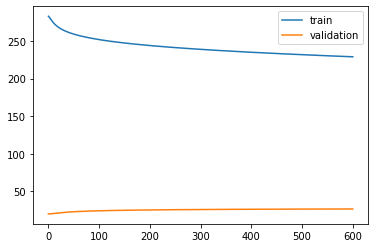

In [ ]:
plt.plot(trainloss, label = 'train')
plt.plot(validationloss, label = 'validation')
plt.legend()
plt.show()

In [ ]:
def test(X_test, Y_test, Z_test): 
    
    checkpoint_dir = './model_4.ckpt'
    checkpoint = tf.train.Checkpoint(model = model)
    latest = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def error(Y_hat, real):
        MNE = np.nanmean(abs((Y_hat[real!=0] - real[real!=0])/(real[real!=0]))) 
        MNB = np.nanmean((Y_hat[real!=0] - real[real!=0])/(real[real!=0]))
        return MNE, MNB
    Y_hat = model([X_test, Z_test], training = False).numpy()
    MNE_corr, MNB_corr = error(Y_hat, Y_test) 
    print('regression Mean Error = ', np.nanmean(abs(Y_hat-Y_test)))
    print('regression Mean Normalized Error = ', MNE_corr)
    print('regression Mean Normalized Bias = ', MNB_corr)
    #print('regression Mean Normalized Bias = ', stats.pearsonr(Y_hat,Y_test))
    
    print(' ')                  
    MNE_ori, MNB_ori = error(X_test, Y_test)
    print('original Mean  Absolute Error = ', np.nanmean(abs(X_test-Y_test)))
    print('original Mean Normalized Error = ', MNE_ori)
    print('original Mean Normalized Bias = ', MNB_ori)
    #print('regression Mean Normalized Bias = ', stats.pearsonr(X_test,Y_test))
    return Y_hat

## validation 模型結果

In [ ]:
##rele
X_test = XData[-30:,:]
Y_test = YData[-30:,:]
Z_test = ZData[-31:-1,:]
#Y_hat = test(X_test, Y_test, Z_test)

regression Mean Error =  5.617503
regression Mean Normalized Error =  0.5058963
regression Mean Normalized Bias =  0.26433182
 
original Mean  Absolute Error =  14.164737
original Mean Normalized Error =  1.0059816
original Mean Normalized Bias =  0.45406935


## 訓練完整資料

In [ ]:
train(XData, YData, ZData, min_regular_x, min_regular_z, select_hy = 0, epochs = epoch + 1, end = 1)

(array([], dtype=float64), array([], dtype=float64), 0)

In [ ]:
#Y_hat = test(X_test, Y_test, Z_test)

regression Mean Error =  5.6175427
regression Mean Normalized Error =  0.5059005
regression Mean Normalized Bias =  0.26433396
 
original Mean  Absolute Error =  14.164737
original Mean Normalized Error =  1.0059816
original Mean Normalized Bias =  0.45406935


In [ ]:
model.save('model4_mse_relu.h5') 

In [ ]:
#files.download('model4.h5')